<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attack detection using CTF dataset

You shouldn't use 'Run All' on this notebook: in the sections 'Dimensionality Reduction' and 'Training' only run one of the subsections for each.
If you run all the cells it won't cause any error, just waste time on operations that will then be overwritten.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.cluster import KMeans, MeanShift, FeatureAgglomeration
from pandas.plotting import scatter_matrix

%matplotlib inline

## Utility Functions

In [55]:
def print_scores(y_test, y_pred):
    y_pred_swapped = [0 if x == 1 else 1 for x in y_pred] 
    
    uniques, counts = np.unique(y_pred, return_counts=True)
    try:
        if counts[1] > counts[0]: # We want the majority class to be benign
            y_pred = y_pred_swapped
    except Exception:
        pass
    
    auroc = metrics.roc_auc_score(y_test, y_pred)
    auroc_swapped = metrics.roc_auc_score(y_test, y_pred_swapped)

    if auroc_swapped > auroc:
        y_pred = y_pred_swapped
        auroc = auroc_swapped

    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Recall = metrics.recall_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    fpr, tpr, threasholds = metrics.roc_curve(y_test, y_pred)

    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN', 'TP']
    group_counts = [f"{value}" for value in
                cf_matrix.flatten()]
    #group_percentages = [f"{value:.2f}%" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='', cmap='Greys', vmin=0, vmax=1, annot_kws={'size': 19}) # thx https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

    print(f"{Accuracy = :,.2%}")
    print(f"{F1 = :,.2%}")
    print(f"{Recall = :,.2%}")
    print(f"{Precision = :,.2%}")
    print(f"Area Under ROC Curve = {auroc:,.2%}")
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.show()

In [ ]:
def load_test(scaler, dimred):
    global test_df

    if 'test_df' not in globals():
        test_df = pd.read_csv(filepath_or_buffer="definitive_dataset.csv")

    X_test = test_df.drop(columns="Label")
    if isinstance(dimred, list):
        X_test = X_test[dimred]

    y_test = test_df["Label"]
    
    X_test = scaler.transform(X_test)
    
    if not isinstance(dimred, list):
        X_test = dimred.transform(X_test)

    return X_test, y_test

In [ ]:
def visualize_features(X):
    corr_matrix = pd.DataFrame(X).corr()
    plt.rcParams['figure.figsize'] = (18, 8)
    g = sns.heatmap(corr_matrix, annot=True, fmt=".1g", cmap="mako")
    g.set_xticklabels(
        g.get_xticklabels(),
        verticalalignment="top",
        horizontalalignment="right",
        rotation=30,
    )
    plt.show()
    scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(20, 20), diagonal="kde")

## Data preparation

In [ ]:
!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/Thu15.csv -O 'CTF Data/dataset_ctf1.csv'
!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/Nazionale2022.csv -O 'CTF Data/dataset_ctf2.csv'
!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/Nazionale2022.csv -O 'CTF Data/dataset_ctf3.csv'

In [ ]:
from pathlib import Path
li = []
for filename in Path('./CTF Data/').glob('*.csv'):
  li.append(pd.read_csv(filename))
df = pd.concat(li, axis=0, ignore_index=True)

#df = pd.read_csv("CTF Data/Thu15.csv")
df.shape

Make sure that there's no null rows

In [ ]:
df = df.drop(df[pd.isnull(df["Flow ID"])].index)
df.shape

Drop Label column since it's useless

In [ ]:
df.drop(columns="Label", inplace=True)
df.shape

Drop all flows pertaining ssh and caronte

In [ ]:
df.drop(df[df["Src Port"] == 22].index, inplace=True)
df.drop(df[df["Dst Port"] == 22].index, inplace=True)
df.drop(df[df["Src Port"] == 3333].index, inplace=True)
df.drop(df[df["Dst Port"] == 3333].index, inplace=True)
df.shape

Drop all flows made by our team

In [ ]:
df.drop(df[df["Src IP"].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.drop(df[df["Dst IP"].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.shape

In [ ]:
df["Src IP"].unique()

I noticed there's some flows belonging to other addresses. This probably means there's an error in the gameserver, leaking some packets. Upon manual inspection of the pcap, I noticed they are mostly FIN/ACK and RST.
I chose to keep these flows as it's still actual traffic and we will be removing the IP features anyway

In [ ]:
df[
    ((df["Src IP"] != "10.254.0.1") & (df["Src IP"] != "10.60.39.1"))
    | ((df["Dst IP"] != "10.254.0.1") & (df["Dst IP"] != "10.60.39.1"))
].shape

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [ ]:
df.replace("Infinity", -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(
    pd.to_numeric
)

Replace the NaN values and infinity values with -1.

In [ ]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [ ]:
excluded = [
    "Flow ID",
    "Src IP",
    "Src Port",
    "Dst IP",
    "Dst Port",
    "Protocol",
    "Timestamp",
]
df.drop(columns=excluded, inplace=True)

## Dimensionality Reduction

We don't have labels to select features based on importance. A simple approach would be using the same features selected on the CIC-IDS-2017 Dataset

### Feature Selection

In [44]:
dimred = [
    "RST Flag Count",
    "Total Length of Fwd Packet",
    "Fwd Packet Length Max",
    "Packet Length Variance",
    "Fwd Packets/s",
    "Fwd Packet Length Mean",
    "Flow IAT Max",
    "Flow Duration",
    "Flow Packets/s",
    "Total TCP Flow Time",
    "PSH Flag Count",
    "Packet Length Min",
    "Bwd IAT Total",
    "FWD Init Win Bytes",
    "Flow Bytes/s",
    "ACK Flag Count",
    "Fwd Header Length",
    "SYN Flag Count",
    "Total Bwd packets",
]
X = df[dimred]

scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
visualize_features(X)

We can see how many of the selected features are practically independent from the dataset. This means they don't bring much information.

### PCA

In [50]:
scaler = RobustScaler()
scaler.fit(df)
X = scaler.transform(df)

dimred = PCA(20, random_state=42)
dimred.fit(X)
X = dimred.transform(X)

In [ ]:
visualize_features(X)

### Feature Agglomeration

In [57]:
scaler = RobustScaler()
scaler.fit(df)
X = scaler.transform(df)

dimred = FeatureAgglomeration(n_clusters=20)
dimred.fit(X)
X = dimred.transform(X)

In [ ]:
visualize_features(X)

## Training


### K-Means

In [40]:
clf: KMeans = KMeans(2, random_state=42, verbose=10)

param_grid = {
    "algorithm": ["lloyd", "elkan"],
    "max_iter": [100, 300, 650, 1000, 2000],
    "n_init": [1, 2, 5, 10, 20],
}
search = HalvingGridSearchCV(clf, param_grid=param_grid, n_jobs=-1, verbose=10).fit(X)
clf: KMeans = search.best_estimator_

X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)
print(search.best_estimator_)
print(search.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 11569
max_resources_: 312374
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 11569
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 2/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 3/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 4/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 5/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 1/5; 2/50] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 2/5; 2/50] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 3/5; 2/50] START algorithm=lloyd, max_iter=100, n_init=2....................


[CV 4/5; 2/50] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 5/5; 2/50] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 1/5; 3/50] START algorithm=lloyd, max_iter=100, n_init=5....................
[CV 2/5; 3/50] START algorithm=lloyd, max_iter=100, n_init=5....................
Initialization complete
[CV 3/5; 3/50] START algorithm=lloyd, max_iter=100, n_init=5....................
Iteration 0, inertia 1.2919611508391158e+18.
Iteration 1, inertia 1.262767366299658e+18.
Initialization complete
Initialization completeIteration 2, inertia 1.2623797410997965e+18.

Initialization complete
Initialization complete
Iteration 0, inertia 1.0378737400031786e+18.
Iteration 3, inertia 1.2623626139332086e+18.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1.1175182667246842e+18.Initialization complete

Iteration 0, inertia 1.2087601219902717e+18.Iteration 1, inertia 1.0082162180148598e+18.
Iteration 0, inertia 1.

### MeanShift

In [43]:
clf = MeanShift(max_iter=300, n_jobs=-1)
clf.fit(X)

"""
MeanShift outputs 107 classes. To project them into binary I iteratively tried considering every class a benign or not, maximizing the F1 score on the test dataset (Corrected CIC-IDS-2017).
I don't think it's a bad idea, but if we do this on the test set then it doesn't hold much weight, we would need another labelled set as validation (best would be to label the ctf dataset)
"""
X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)

benign_classes = []
y_pred_tmp = y_pred.tolist()
classes = np.unique(y_pred)
for c in classes:
    y_pred_ben = [0 if x == c else x for x in y_pred_tmp]
    y_pred_att = [1 if x == c else x for x in y_pred_tmp]

    y_pred_ben = [1 if x != 0 else x for x in y_pred_ben]
    y_pred_att = [1 if x != 0 else x for x in y_pred_att]

    F1_B = metrics.f1_score(y_test, y_pred_ben)
    F1_A = metrics.f1_score(y_test, y_pred_att)

    print(f"F1 with class {c} as BENIGN: {F1_B}")
    print(f"F1 with class {c} as ATTACK: {F1_A}")
    print("\n")
    if F1_B > F1_A:
        benign_classes.append(c)
    y_pred_tmp = [0 if x in benign_classes else x for x in y_pred]

# print(f"{benign_classes = }")
y_pred = [1 if x != 0 else x for x in y_pred_tmp]

KeyboardInterrupt: 

### Isolation Forest

In [58]:
clf: IsolationForest = IsolationForest(
    n_estimators=200, max_features=10, bootstrap=True, random_state=42, verbose=1
)

clf.fit(X)

X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)  # output is -1 | 1
y_pred = [0 if x == -1 else 1 for x in y_pred]

## Testing

FeatureAgglomeration(n_clusters=20)
<class 'sklearn.ensemble._iforest.IsolationForest'>
Accuracy = 55.85%
F1 = 44.08%
Recall = 58.02%
Precision = 35.55%
Area Under ROC Curve = 56.47%


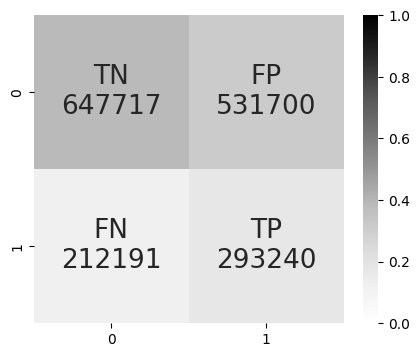

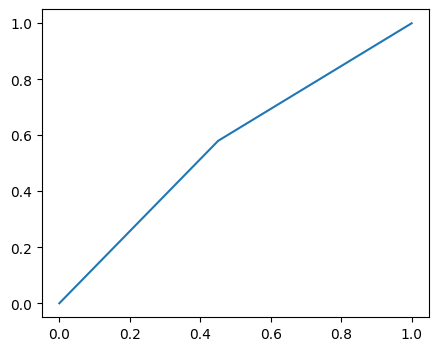

In [59]:
print(dimred)
print(type(clf))
print_scores(y_test, y_pred)